# Fashion MNIST
An MNIST-like dataset of 70,000 28x28 labeled fashion images

<img src='../input/artificial-photography-vB5qtt8X4NA-unsplash.jpg' height="500">

Photo by [Artificial Photography](https://unsplash.com/@artificialphotography)

## Context
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.


## Content
* Each row is a separate image of 28 pixels in height and 28 pixels in width
* Column 1 is the class label.
* Remaining columns are pixel numbers (784 total).
* Each value is the darkness of the pixel (1 to 255) with higher numbers meaning darker
* The first column consists of the class labels (see below), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

## Goal
Use a neural network on a simple classification task (classifaction of clothes' images into 10 classes). For learning purpose i'll use a Multi Layer Perceptron, but __there might be better type of NN such as CNN__.

---

# Data exploration

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [25]:
X_train = pd.read_csv('../input/fashion-mnist_train.csv')
X_test = pd.read_csv('../input/fashion-mnist_test.csv')

X_train.shape, X_test.shape

((60000, 785), (10000, 785))

In [26]:
X_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Splitting features and targets

In [27]:
y_train, y_test = X_train['label'], X_test['label']
X_train, X_test = X_train.iloc[:, 1:], X_test.iloc[:, 1:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [28]:
X_train, X_test = np.array(X_train), np.array(X_test)
type(X_train)

numpy.ndarray

This dataset contains 10 classes:
* 0:	T-shirt/top
* 1:	Trouser
* 2:	Pullover
* 3:	Dress
* 4:	Coat
* 5:	Sandal
* 6:	Shirt
* 7:	Sneaker
* 8:	Bag
* 9:	Ankle boot

In [29]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

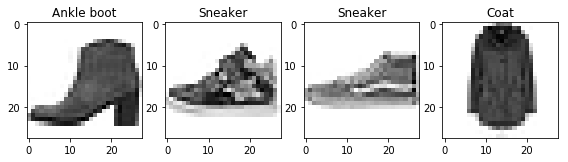

In [30]:
# display 5 randomly choosen clothes
plt.figure(figsize=(12, 5))

for i in range(1, 5):
    plt.subplot(1, 5, i)
    num = np.random.randint(X_train.shape[0])
    plt.imshow(X_train[num].reshape(28, 28), cmap='gray_r')
    plt.title(class_names[y_train[num]])

plt.show()

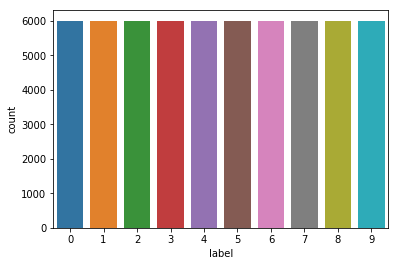

In [31]:
# number of clothes for each class
sns.countplot(y_train)

There isn't any imbalaced class. All have the same number of objects.

---

# Data preparation

Scaling data

In [32]:
X_train = X_train/255
X_test = X_test/255
X_train.mean(), X_test.mean()

(0.2861052180872351, 0.2869051175470186)

No need to resape 28 x 28 images since the already come as flatten np.array of dimension 784.

Let's make categories of the different classes (similar to the label encoding in sklearn but using the Keras function `to_categorical`)

In [33]:
nb_class = len(class_names)

y_train_cat = to_categorical(y_train, num_classes=nb_class, dtype='float32')
y_test_cat  = to_categorical(y_test , num_classes=nb_class, dtype='float32')

y_train.shape, y_train_cat.shape, y_test.shape, y_test_cat.shape

((60000,), (60000, 10), (10000,), (10000, 10))

---

# Model creation, training and results 

## MLP theory 

Source: [deepai.org](https://deepai.org/machine-learning-glossary-and-terms/multilayer-perceptron)

The Perceptron consists of an input layer and an output layer which are fully connected.  MLPs have the same input and output layers but may have multiple hidden layers in between the aforementioned layers, as seen below.

<img src='../input/multipercep.jpg' height="500">

The algorithm for the MLP is as follows:

* Just as with the perceptron, the inputs are pushed forward through the MLP by taking the dot product of the input with the weights that exist between the input layer and the hidden layer (W­­­H).  This dot product yields a value at the hidden layer. We do not push this value forward as we would with a perceptron though.


* MLPs utilize activation functions at each of their calculated layers.  There are many activation functions to discuss: rectified linear units (ReLU), sigmoid function, tanh.  Push the calculated output at the current layer through any of these activation functions.

* Once the calculated output at the hidden layer has been pushed through the activation function, push it to the next layer in the MLP by taking the dot product with the corresponding weights.

* Repeat steps two and three until the output layer is reached.


* At the output layer, the calculations will either be used for a backpropagation algorithm that corresponds to the activation function that was selected for the MLP (in the case of training) or a decision will be made based on the output (in the case of testing).



MLPs form the basis for all neural networks and have greatly improved the power of computers when applied to classification and regression problems.  Computers are no longer limited by XOR cases and can learn rich and complex models thanks to the multilayer perceptron.



## Architecture

Let's build our neural network architecture with Keras. We start with a one.

In [34]:
feat_nb = X_train.shape[1]

In [35]:
def create_model(nb_hidden_layers, nb_units):
    model = Sequential()
    
    # 1st layer non hidden
    model.add(Dense(nb_units, input_dim=feat_nb, activation='sigmoid'))
    
    # all hidden layer
    for _ in range(nb_hidden_layers):
        model.add(Dense(nb_units, activation='sigmoid'))
    
    # using softmax for the activiation of the last layer since this is a multi class classification 
    model.add(Dense(nb_class, activation='softmax'))
    
    print(model.summary())
    return model

In [36]:
# creation of a MLP with 2 hidden layers, all layers have 10 units
mlp = create_model(2, 10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
Total params: 8,180
Trainable params: 8,180
Non-trainable params: 0
_________________________________________________________________
None


## Compilation and training

Now compile and fit the model on the training data. Since this is a multiclass classification, the loss is `categorical_crossentropy`.

In [37]:
# Compile model
mlp.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
# Fit model 
mlp.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=60, batch_size=32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 51us/sample - loss: 0.7420 - acc: 0.7304 - val_loss: 0.7478 - val_acc: 0.7203
Epoch 2/20
60000/60000 [==============================] - 3s 52us/sample - loss: 0.7304 - acc: 0.7337 - val_loss: 0.7353 - val_acc: 0.7327
Epoch 3/20
60000/60000 [==============================] - 3s 52us/sample - loss: 0.7195 - acc: 0.7390 - val_loss: 0.7260 - val_acc: 0.7303
Epoch 4/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.7085 - acc: 0.7428 - val_loss: 0.7144 - val_acc: 0.7377
Epoch 5/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.6978 - acc: 0.7466 - val_loss: 0.7045 - val_acc: 0.7430
Epoch 6/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.6868 - acc: 0.7514 - val_loss: 0.6928 - val_acc: 0.7462
Epoch 7/20
60000/60000 [==============================] - 3s 54us/sample - loss: 0.6759 - acc: 0.7565 - val_loss: 0.

## Results

Once our model is trained, let's compute the accuracy on the train and test datasets.

Beware, Keras returns softmax output (so an array of 10 values between 0 and 1, for which the sum is equal to 1). To compute correctly the accuracy, you have to convert that array into a categorical array with zeros and a 1.

In [43]:
loss, accuracy = mlp.evaluate(X_test, y_test_cat)
loss, accuracy

10000/10000 [==============================] - 0s 20us/sample - loss: 0.5519 - acc: 0.8166


(0.5519142246246338, 0.8166)

In [44]:
y_pred = mlp.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_pred

array([0, 1, 2, ..., 8, 8, 0])

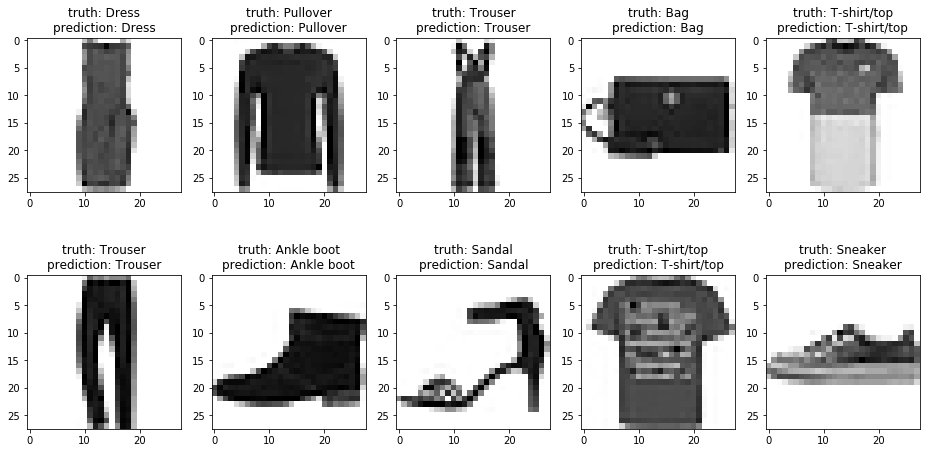

In [45]:
# display 10 randomly choosen clothes with predicted labels and ground truth
plt.figure(figsize=(16, 8))

for i in range(1, 11):
    plt.subplot(2, 5, i)
    num = np.random.randint(X_test.shape[0])
    plt.imshow(X_test[num].reshape(28, 28), cmap='gray_r')
    title = 'truth: ' + class_names[y_test[num]] + '\nprediction: ' + class_names[y_pred[num]]
    plt.title(title)

plt.show()